## 뉴스 요약봇 만들기

### 1. 추상적 요약
#### 데이터 수집

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

headlines  \
14037  I myself couldn't sit through my own film Chup...   
76306  Peon arrested for raping 4-year-old in Mumbai ...   
86529  Airbnb hosts reject disabled guests more often...   
72447  Nazi Germany was almost 100% Catholic : BJP to...   
10799  Tencent builds self-driving car team in Silico...   
87318      Trump delays decision on Paris climate accord   
70505  49,000 Aadhaar operators blacklisted for overc...   
87142  What is significance of Germany saying it can'...   
70603  PETA, photographer reach settlement over monke...   
13838  FIR against ex-Assam CM Gogoi for alleged frau...   

                                                    text  
14037  Actor Shahid Kapoor has said he himself couldn...  
76306  A four-year-old girl was allegedly raped by a ...  
86529  A new study by researchers has found that Airb...  
72447  Slamming an article published by a Goa Church ...  
10799  Tencent is building a research team for its "A...  
87318  US President Donald Trump refused to endorse t...  
70505  The Unique Identification Authority of India (...  
87142  German Chancellor Angela Merkel has said that ...  
70603  PETA and photographer David Slater have reache...  
13838  The Assam Police has registered an FIR against...

### 데이터 전처리

#### 중복 값과 Null 값 제거

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화, 불용어 제거

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    if remove_stopwords: # 불용어 제거
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else: # 불용어 미제거
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
clean_text = []
# 전체 Text 데이터 전처리
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []

# 전체 Summary 데이터 전처리
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))  

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈값은 Null로
data.replace('', np.nan, inplace=True)

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 훈련 데이터 테스트 데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


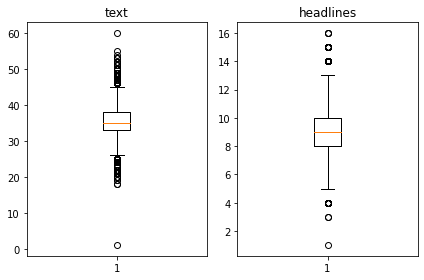

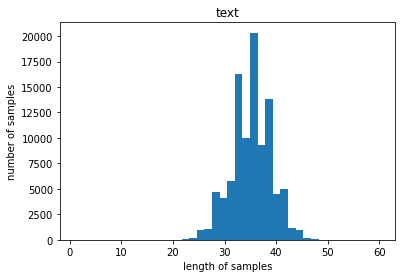

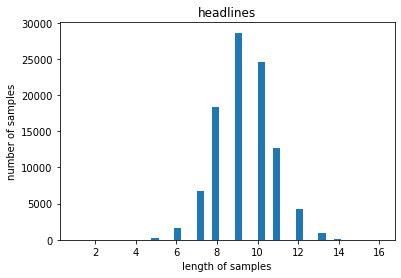

In [14]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 60  
headlines_max_len = 16

In [16]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [19]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

headlines  \
0  upgrad learner switches to career in ml al wit...   
1  delhi techie wins free food from swiggy for on...   
2  new zealand end rohit sharma led india match w...   
3  aegon life iterm insurance plan helps customer...   
4  have known hirani for yrs what if metoo claims...   

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   

                                       decoder_input  \
0  sostoken upgrad learner switches to career in ...   
1  sostoken delhi techie wins free food from swig...   
2  sostoken new zealand end rohit sharma led indi...   
3  sostoken aegon life iterm insurance plan helps...   
4  sostoken have known hirani for yrs what if met...   

                                      decoder_target  
0  upgrad learner switches to career in ml al wit...  
1  delhi techie wins free food from swiggy for on...  
2  new zealand end rohit sharma led india match w...  
3  aegon life iterm insurance plan helps customer...  
4  have known hirani for yrs what if metoo claims...

In [20]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target']) 

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[84219 27630 46893 ... 30779 38415 19331]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 정수 인코딩
#### 단어집합 만들기

In [25]:
src_tokenizer = Tokenizer() 
src_tokenizer.fit_on_texts(encoder_input_train) 

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69633
등장 빈도가 6번 이하인 희귀 단어의 수: 47451
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22182
단어 집합에서 희귀 단어의 비율: 68.14441428632976
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.477391163595267


In [27]:
src_vocab = 8000 # 단어 집합 크기 제한
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

In [28]:
# 텍스트 seq를 정수 seq로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[210, 455, 182, 60, 3245, 707, 970, 438, 5, 2419, 103, 970, 899, 236, 34, 7263, 130, 181, 221, 103, 667, 457, 5879, 4232, 7149, 34, 899, 367, 3911, 899, 6, 156, 6790, 6335, 1405, 707], [65, 42, 50, 209, 440, 107, 2437, 144, 93, 40, 1896, 22, 5446, 558, 757, 521, 40, 300, 3355, 2063, 30, 757, 147, 158], [329, 20, 466, 721, 104, 664, 3705, 38, 2564, 941, 1532, 2986, 664, 883, 926, 1011, 1532, 38, 1896, 3705, 305, 296, 126, 98, 38, 1435, 3705, 1533, 1699, 20, 397]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30016
등장 빈도가 5번 이하인 희귀 단어의 수: 19601
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10415
단어 집합에서 희귀 단어의 비율: 65.30183901918977
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.64544901482422


In [31]:
tar_vocab = 2000 
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 98, 1704, 51, 509, 3, 598, 637, 659, 1136], [1, 140, 151, 10, 1311, 68, 145, 524], [1, 20, 3, 72, 14, 371, 11, 15, 176, 60], [1, 503, 42, 820, 3, 196, 1396, 643], [1, 300, 3, 170, 74, 4, 58, 582, 1081, 135]]
target
decoder  [[98, 1704, 51, 509, 3, 598, 637, 659, 1136, 2], [140, 151, 10, 1311, 68, 145, 524, 2], [20, 3, 72, 14, 371, 11, 15, 176, 60, 2], [503, 42, 820, 3, 196, 1396, 643, 2], [300, 3, 170, 74, 4, 58, 582, 1081, 135, 2]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 78678
훈련 레이블의 개수 : 78678
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


#### 패딩

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

#### 모델 설계

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [36]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Attention

In [37]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 256s 803ms/step - loss: 2.9494 - val_loss: 2.7207
Epoch 2/50
308/308 [==============================] - 246s 798ms/step - loss: 2.5829 - val_loss: 2.4701
Epoch 3/50
308/308 [==============================] - 245s 796ms/step - loss: 2.3769 - val_loss: 2.3075
Epoch 4/50
308/308 [==============================] - 245s 797ms/step - loss: 2.2330 - val_loss: 2.1995
Epoch 5/50
308/308 [==============================] - 244s 794ms/step - loss: 2.1290 - val_loss: 2.1218
Epoch 6/50
308/308 [==============================] - 246s 797ms/step - loss: 2.0473 - val_loss: 2.0618
Epoch 7/50
308/308 [==============================] - 246s 798ms/step - loss: 1.9791 - val_loss: 2.0147
Epoch 8/50
308/308 [==============================] - 245s 797ms/step - loss: 1.9215 - val_loss: 1.9784
Epoch 9/50
308/308 [==============================] - 244s 794ms/step - loss: 1.8706 - val_loss: 1.9446
Epoch 10/50
308/308 [==============================] - 245s 795m

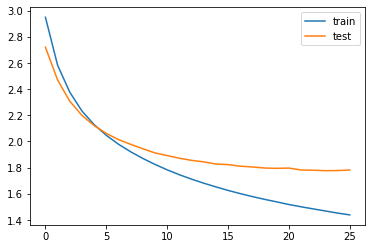

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현

In [40]:
src_index_to_word = src_tokenizer.index_word 
tar_word_to_index = tar_tokenizer.word_index 
tar_index_to_word = tar_tokenizer.index_word 

In [41]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트

In [44]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : karnataka cabinet thursday cleared state policy transgenders rights policy aims provide transgenders secure life creating awareness community workers would people children rights workers also address issues pertaining discrimination sexual abuse violence transgenders 
실제 요약 : taka cabinet clears policy to transgender rights 
예측 요약 :  karnataka cabinet approves new policy


원문 : one person killed two others injured friday attack man melbourne australia police said treating attack terror incident attacker shot police later succumbed injuries hospital 
실제 요약 : killed injured in terror attack 
예측 요약 :  killed injured in attack in


원문 : former argentina captain world cup winner diego maradona seen smoking stands argentina match despite smoking tobacco banned fifa world cup year old also accused making racist gesture visiting korean fans watching match stands 
실제 요약 : despite smoking ban at fifa world cup 
예측 요약 :  world cup winning player hacked to play smoking in


원문 : idea cellular

### 추출적 요약
#### Summarize

In [46]:
import requests
from summa.summarizer import summarize

In [47]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [48]:
data.sample(10)

headlines  \
27481  10 dead in blast at firecracker unit in Telangana   
38433  Man thrashed by govt official for misbehaving ...   
63417  Philippine police chief hints at possible run ...   
60451  Lankan Army chief summoned over disappearance ...   
88391  My brother could've been alive today: Sarabjit...   
36733  Anne slams trolls who will fat shame her over ...   
74938   Delhi zoo starts free pram services for toddlers   
80747  Data of 60 lakh customers of 2nd largest US te...   
1186   Shah Rukh's son Aryan Khan's Facebook account ...   
63703  RT reveals Twitter's elections sales pitch aft...   

                                                    text  
27481  At least 10 workers lost their lives while sev...  
38433  A 32-year-old man was allegedly thrashed by a ...  
63417  The Philippines' top police chief Ronald Dela ...  
60451  A Sri Lankan court has summoned the country's ...  
88391  Dalbir Kaur, the sister of Sarabjit Singh, who...  
36733  Anne Hathaway shared an Instagram video where ...  
74938  Delhi's National Zoological Park on Wednesday ...  
80747  The second largest US telecom company Verizon ...  
1186   Facebook account of Shah Rukh Khan's son Aryan...  
63703  Representatives from Twitter had made a multi-...

In [49]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.40))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

### 회고
Exploration 11, 12를 통해 텍스트 요약을 경험해보았다. 11에서는 한국어를 요약해보았고, 12에서는 영어를 요약했다. 같이 프로그래밍한 동료는 20 언저리의 에폭까지 가고, early stop 되었는데 나는 26 에폭을 수행하고 early stop 되었다. 이에 대해, 생각해보는 시간을 가져보았고, 나중에 코드(하이퍼 파라미터)를 수정해보면서 만지작 해봐야겠다.